# ACTS-MU10-PT1000-T50

In [2]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [2]:
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/opt/conda/lib/python3.5/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/opt/conda/lib/python3.5/site-packages/theano/gpuarray/__init__.py", line 60, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 634, in pygpu.gpuarray.init
  File "pygpu/gpuarray.pyx", line 584, in pygpu.gpuarray.pygpu_init
  File "pygpu/gpuarray.pyx", line 1057, in pygpu.gpuarray.GpuContext.__cinit__
pygpu.gpuarray.GpuArrayException: b'cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected'


### Load in the data.

In [4]:
filepath  = "data/sets/ACTS/ACTS-MU10-PT1000-COMPLETE.gz"
frame = pd.read_csv(filepath)
frame.head(5)

,Unnamed: 0,hit_number,cluster_id,volume_id,layer_id,local_x,local_y,local_x_error,local_y_error,x,...,theta_error,event_id,vertex_x,vertex_y,vertex_z,momentum,momentum_theta,momentum_phi,charge,r
0,57,13,9007611571601408,8,2,0.175000,-12.81660,0.15,0.15,-31.6402,...,0.01,1,-0.017461,-0.003923,-22.3766,2.25170,2.23929,2.944980,-1,31.959895
1,58,25,9007611571601408,8,4,7.875000,26.50210,0.15,0.15,-69.8725,...,0.01,1,-0.017461,-0.003923,-22.3766,2.25170,2.23929,2.944980,-1,71.842967
2,60,40,9007611571601408,8,6,0.508291,-8.72822,0.15,0.15,-113.8750,...,0.01,1,-0.017461,-0.003923,-22.3766,2.25170,2.23929,2.944980,-1,115.818695
3,61,51,9007611571601408,8,8,5.875000,17.14790,0.15,0.15,-169.1290,...,0.01,1,-0.017461,-0.003923,-22.3766,2.25170,2.23929,2.944980,-1,171.809967
4,12,8,9008298766368768,8,2,5.407350,-16.95940,0.15,0.15,29.3553,...,0.01,1,-0.017461,-0.003923,-22.3766,5.85017,2.83551,0.361795,-1,31.959895


In [5]:
%%time
max_tracks = 50
filt   = lambda a: len(a["cluster_id"].unique()) <= max_tracks
events = frame.groupby("event_id").filter(filt)

CPU times: user 32.8 s, sys: 37.7 s, total: 1min 10s
Wall time: 1min 10s


In [ ]:
a = events.groupby("event_id")
#print(len(events))
#print(len(events["event_id"].unique()))
print(max([len(e["cluster_id"].unique()) for (_, e) in a]))

In [ ]:
%%time
savepath = "data/sets/ACTS/ACTS-MU10-PT1000-T50-PREPARED.gz"
prepared = ext.prepare_frame(events, n_tracks=50, n_rows=200)

In [6]:
%%time
modelpath = "data/models/ACTS-MU10-PT1000-T50.h5"
filepath  = "data/sets/ACTS/ACTS-MU10-PT1000-T50-PREPARED.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del events

Train is list of 52325 events.
Test is list of 13082 events.
Train takes up 418664 bytes.
Test takes up 104720 bytes.
CPU times: user 41.7 s, sys: 1min 14s, total: 1min 56s
Wall time: 1min 56s


In [7]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

### Show an example of the data.

Train 34809
Number of Hits: 147
Number of Tracks: 41


<IPython.core.display.Javascript object>


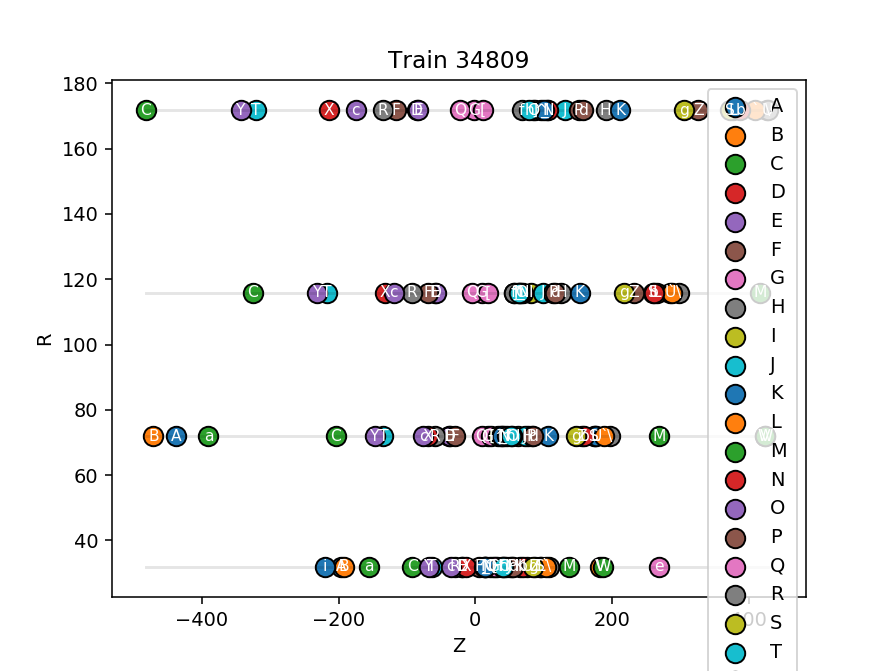

<IPython.core.display.Javascript object>


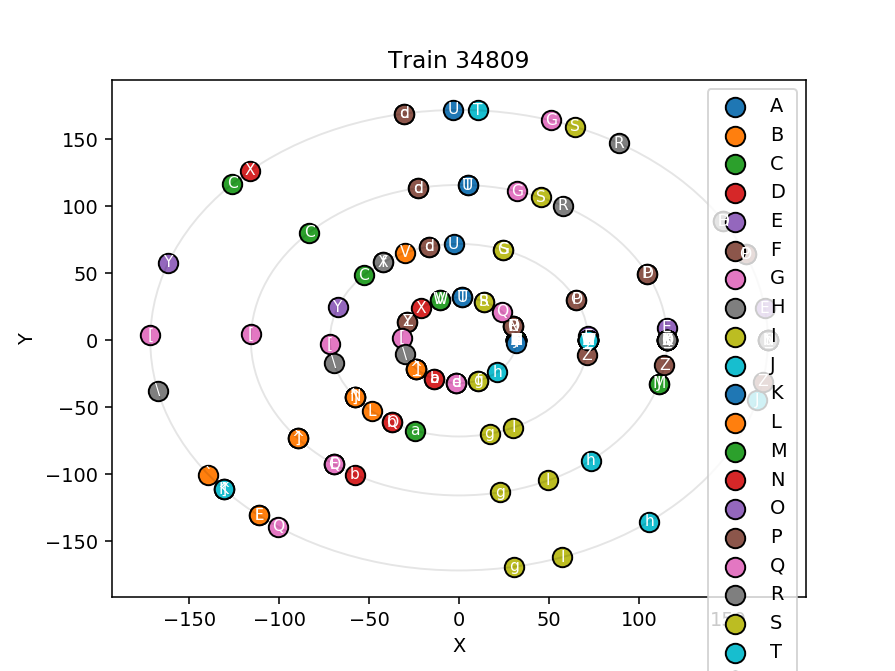

In [8]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [9]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,[,\,],^,_,`,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,padding
0,0.0,31.959895,-196.60000,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,31.959895,-192.18400,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,31.959895,-91.95000,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.0,31.959895,-19.44690,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,0.0,31.959895,-19.22190,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,0.0,31.959895,4.74586,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,0.0,31.959895,25.84330,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0.0,31.959895,31.09060,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,0.0,31.959895,45.36410,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,0.0,31.959895,50.15060,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [10]:
input_shape  = (200, 3)
n_categories = 50 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [ ]:
model = keras.models.load_model(modelpath)

In [11]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 200, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 52)           13364     
Total para

### Fit the model.

In [ ]:
%%time
epochs     = 128
batch_size = 50
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Epoch 1/128
   5/1046 [..............................] - ETA: 14207s - loss: 3.9129 - acc: 0.4661

### Display information about the model after fitting it.

In [ ]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

### Display how one of the model's predictions looks.

In [ ]:
%matplotlib notebook

In [ ]:
n  = np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
#_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
#_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
#_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

In [ ]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

In [ ]:
%%time
for percent in [0.3, 0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

In [ ]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)

In [ ]:
bad_tracks = []
for i in range(len(test)):
    if ext.extract_output(test[i], order)[0, 0] == 1:
        bad_tracks.append(test[i])
bad_guesses = model.predict(ext.extract_input(bad_tracks, order))
print(metrics.percent_of_hits_assigned_correctly(bad_tracks, bad_guesses, order))

In [ ]:
importlib.reload(metrics)

In [ ]:
print(min([event["momentum"].min() for event in test]))
print(max([event["momentum"].max() for event in test]))

In [ ]:
%%time
momentums = [1 + 1/8, 1 + 1/4, 1 + 1/2, 2, 4, 8, 16, 32, 64, 128]
momentums, momentum_acc = metrics.accuracy_vs_momentum(test, guesses, order, momentums)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
for acc in momentum_acc:
    print(len([b for b in acc if b == 1]) / len(acc))

In [ ]:
for i, momentum in enumerate(momentums):
    accuracy = momentum_acc[i]
    if accuracy:
        plt.hist(accuracy, bins=5, range=(0, 1), align="mid", edgecolor='black', linewidth=2, color='green')
        plt.title("Momentum: {0} - {1}".format(momentums[i-1] if i > 0 else 1, momentum))
        plt.xlabel("Probability that hit within track was correctly classified")
        plt.ylabel("Tracks with this momentum")
        plt.grid(True)
        plt.show()

In [ ]:
%matplotlib notebook
visuals.boxplot(
    data   = momentum_acc.tolist(),
    fliers = True,
    ylabel = "Probability",
    xlabel = "Momentum",
    title  = "Prob[Hit within track belongs to track] vs Momentum",
    xticks = momentums
)

In [ ]:
%%time
bend_amounts = [i for i in range(0, 500, 25)]
bends, acc = metrics.accuracy_vs_bend(test, guesses, order, bend_amounts)
visuals.boxplot(
    data   = acc.tolist(),
    fliers = False,
    ylabel = "Probability",
    xlabel = "Bending",
    title  = "Prob[Hit within track belongs to track] vs Track Bend",
    xticks = bends
)

In [ ]:
print(len(test))

In [ ]:
%%time
boxes = [[] for _ in range(30)]
for i, event in enumerate(test):
    crossings    = metrics.number_of_crossings(event)
    hits_correct = metrics.percent_of_hits_assigned_correctly(event, guesses[i], order) 
    boxes[crossings].append(hits_correct)
visuals.boxplot(
    data   = boxes,
    fliers =False,
    ylabel = "Probability",
    xlabel = "Crosses",
    title  = "Prob[Hit belongs to right track in event] vs Number of Crossings",
    xticks = [i for i in range(len(boxes))]
)